# Imports and Configurations

In [205]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm
from util.StringObjectParser import StringObjectParser


In [206]:
sns.set_theme(style="whitegrid")

# Load Data

## NL to SQL Performance

In [207]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")
data_directory = current_directory.replace("/src", "/nl_sql_results")

xlsx_files = [file for file in os.listdir(data_directory) if file.endswith(".xlsx")]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(data_directory, xf))
    xf_bits = xf.split("-")
    df["subsetting_method"] = xf_bits[1]
    df["benchmark"] = xf_bits[2]
    df["comments"] = xf_bits[4].replace(".xlsx", "")
    dataframes.append(df)
nlsql_performance_df = pd.concat(dataframes, ignore_index=True)

The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/src


## Subsetting Performance

In [208]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")
data_directory = current_directory.replace("/src", "/subsetting_results")

xlsx_files = [file for file in os.listdir(data_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(data_directory, xf))
    df["subsetting_method"] = xf.split("-")[1]
    df["benchmark"] = xf.split("-")[2]
    df["comments"] = xf.split("-")[4].replace(".xlsx", "")
    dataframes.append(df)
subset_performance_df = pd.concat(dataframes, ignore_index=True)
for column in subset_performance_df.columns:
    subset_performance_df[column] = subset_performance_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/src


/data/kluoma/skalpel-subsetting-evaluation/src/util/StringObjectParser.py:58: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")


## Schema Stats

In [209]:
current_directory = f"{os.getcwd()}/benchmark_schema_stats"
data_directory = current_directory.replace("/src", "/subsetting_results")

json_files = [file for file in os.listdir(data_directory) if file.endswith('_stats.json')]
df_dict = {"benchmark": [], "database": [], "table_count": [], "column_count": []}
for filename in json_files:
    fn_split = filename.split("_")
    stat_dict = json.loads(open(f"{data_directory}/{filename}", "r").read())
    for k in stat_dict:
        df_dict["benchmark"].append(fn_split[0])
        df_dict["database"].append(k)
        df_dict["table_count"].append(stat_dict[k]["table_count"])
        df_dict["column_count"].append(stat_dict[k]["column_count"])
schema_stat_df = pd.DataFrame(df_dict).query("benchmark!='abstract'")
for column in schema_stat_df.columns:
    schema_stat_df[column] = schema_stat_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

# Process Data

## Model Filter

In [210]:
comment_model_filter = {
    "CodeS": "lambda1_sic_merged",
    "DINSQL": "gpt41",
    "chess": "gpt4o",
    "crush4sql": "lambda1",
    "dtssql": "lambda1",
    "rslsql": "gpt41",
    "tasql": "gpt41",
    "skalpel": "vector_qdecomp_525th",
    "skalpeltasql": "gpt41nano-vectorsort",
    "perfect_subsetter": "oracle",
    "perfect_table_subsetter": "oracle",
    "nosubset": "fullschema"
}

## Display Data Maps

In [211]:
subsetting_display_names = {
    "crush4sql": "Crush",
    "rslsql": "RSLSQL",
    "tasql": "TASQL",
    "CodeS": "CodeS",
    "dtssql": "DTSSQL",
    "chess": "CHESS",
    "DINSQL": "DINSQL",
    "skalpel": "Skalpel",
    "skalpeltasql": "Skalpel+TASQL",
    "perfect_subsetter": "Perfect",
    "perfect_table_subsetter": "Perfect-Table",
    "nosubset": "FullSchema"
}

In [212]:
subsetting_classifications = {
    "crush4sql": "Hyb",
    "rslsql": "LLM",
    "tasql": "LLM",
    "CodeS": "ML",
    "dtssql": "LLM",
    "chess": "Hyb",
    "DINSQL": "LLM",
    "Skalpel": "Hyb",
    "Skalpel+TASQL": "Hyb",
    "perfect_subsetter": "Oracle",
    "perfect_table_subsetter": "Oracle",
    "nosubset": "Full"
}

In [213]:
subsetting_display_order = {
    "Crush": 80,
    "RSLSQL": 40,
    "TASQL": 50,
    "CodeS": 90,
    "DTSSQL": 100,
    "CHESS": 70,
    "DINSQL": 60,
    "Skalpel": 30,
    "Skalpel+TASQL": 35,
    "Perfect": 10,
    "Perfect-Table": 20,
    "FullSchema": 1000
}

## Process Performance Data

In [214]:
nlsql_performance_df["Subsetting Method"] = nlsql_performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])
subset_performance_df["Subsetting Method"] = subset_performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [215]:
nlsql_performance_df["eval_model"] = nlsql_performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )
subset_performance_df["eval_model"] = subset_performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )
nlsql_performance_df["nl_sql_model"] = nlsql_performance_df.nl_sql_model.fillna("openai/gpt-oss-120b")

In [216]:
nlsql_performance_df["method_order"] = nlsql_performance_df["Subsetting Method"].apply(
    lambda x: subsetting_display_order[x]
    )

# Execution Accuracy for Each Subsetting Method

## Execution accuracy by benchmark, LLM, and subsetting method

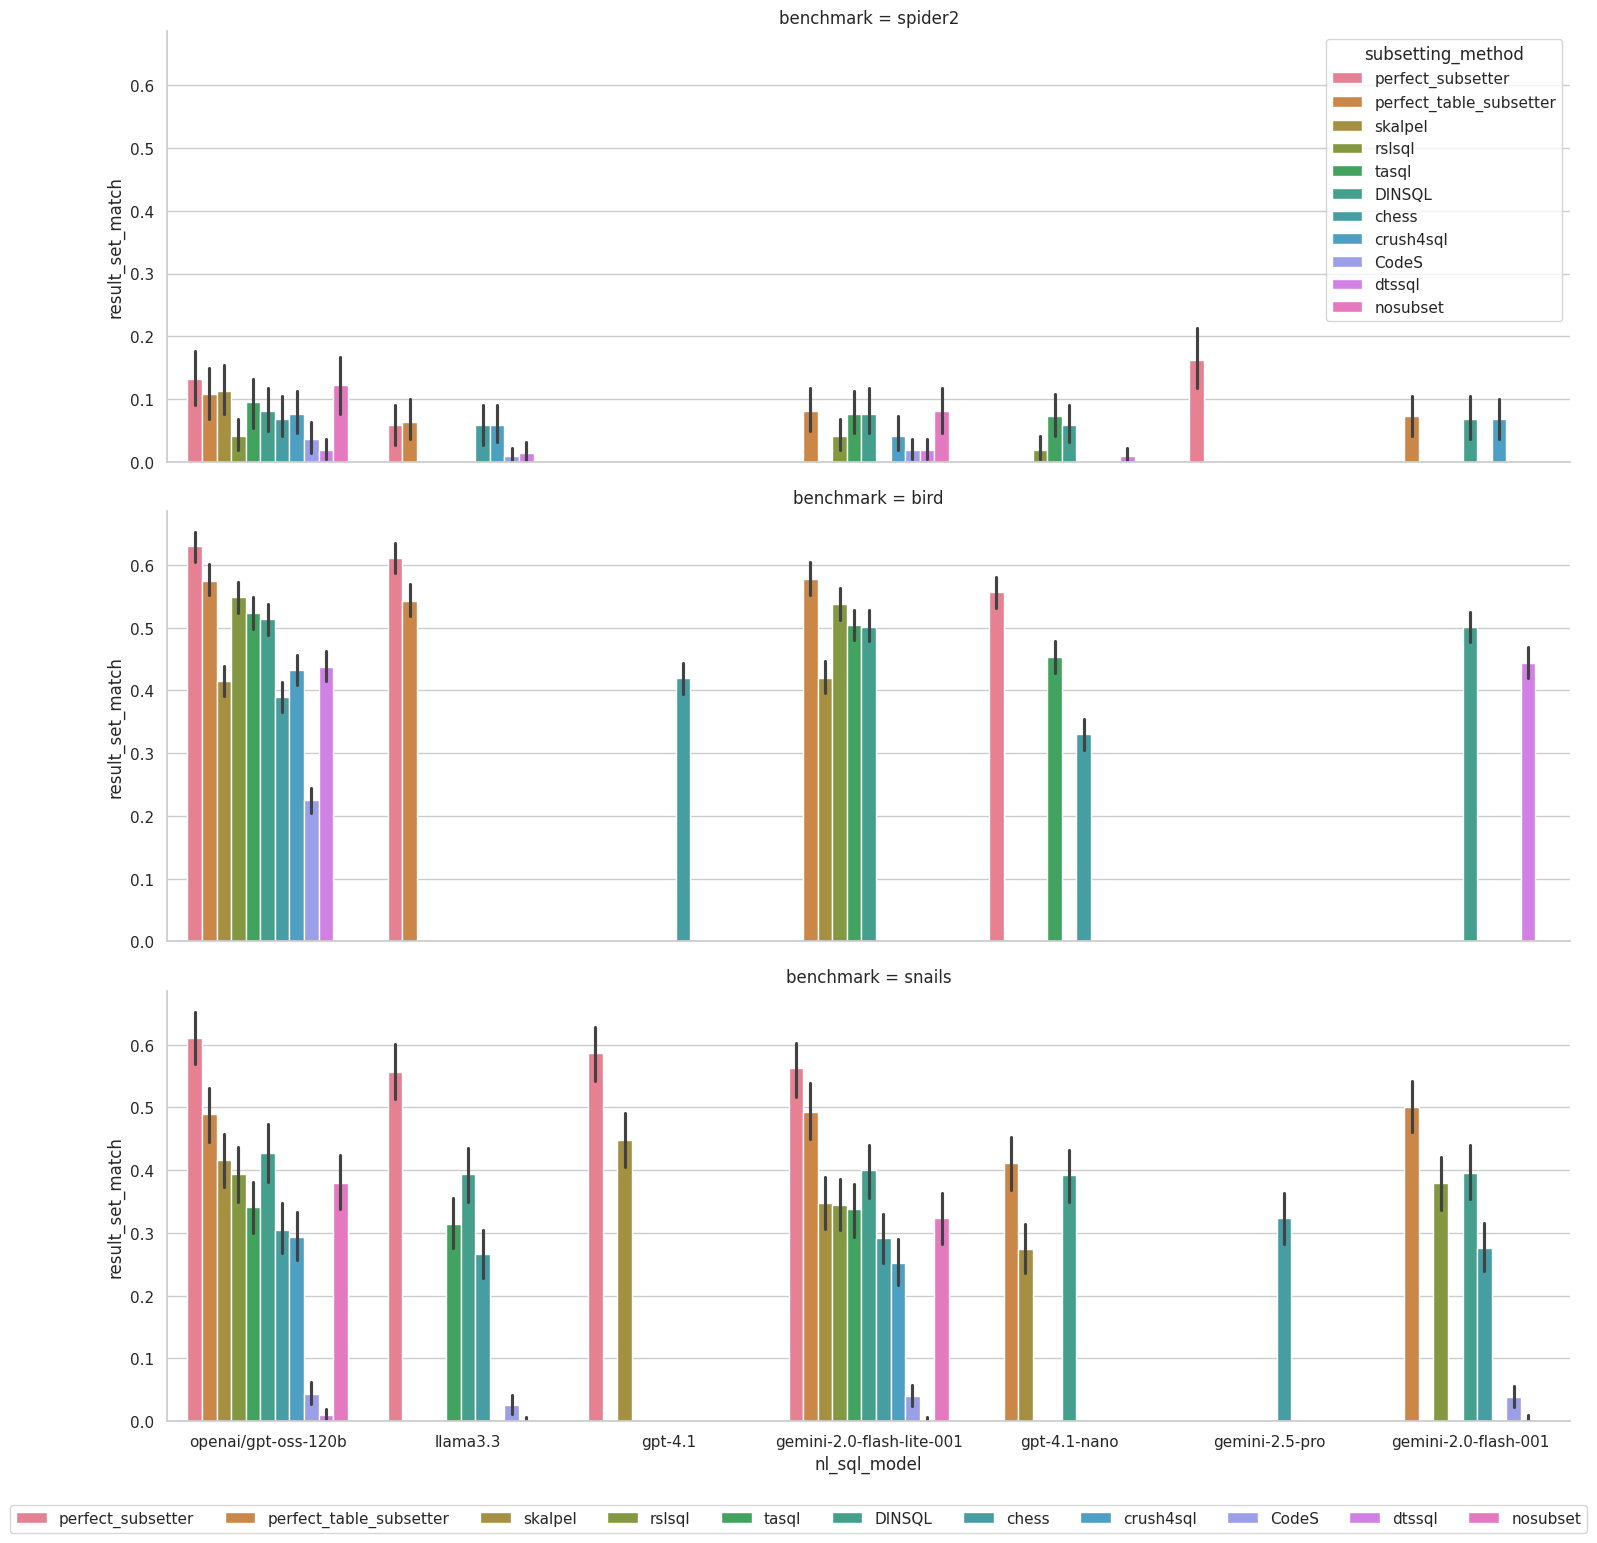

In [217]:
g = sns.catplot(
    data=nlsql_performance_df.query("eval_model").sort_values(by="method_order"),
    x="nl_sql_model",
    y="result_set_match",
    kind="bar",
    hue="subsetting_method",
    aspect=3,
    col="benchmark",
    col_wrap=1,
    legend_out=False,
    # legend=False
)
plt.legend(bbox_to_anchor=(0.45, -0.26), loc='lower center', borderaxespad=0, ncols=11)


